# STA 4003 Group Project

# 测试用 完整代码在STL.py !!!!!!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def stl_factor(path, column, start, period):
    factor = pd.read_csv(path)
    factor['date'] = pd.to_datetime(factor['datetime'])
    factor = factor[factor["date"] > pd.to_datetime(start)]  # 只取2025年一月一日之后的
    factor["factor"] = factor[column]
    factor = factor[["date", "factor"]]
    factor.set_index('date', inplace=True)


    # STL分解
    stl_F = STL(factor['factor'], 
            period=period,  # 季节周期（天）
            robust=True)  # 使用稳健方法
    result_F = stl_F.fit()

    # 可视化分解结果
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    result_F.observed.plot(ax=axes[0], title='Raw data')
    result_F.trend.plot(ax=axes[1], title='tendency')
    result_F.seasonal.plot(ax=axes[2], title='seasonal')
    result_F.resid.plot(ax=axes[3], title='residual')
    plt.tight_layout()
    plt.show()
    
    return result_F, factor

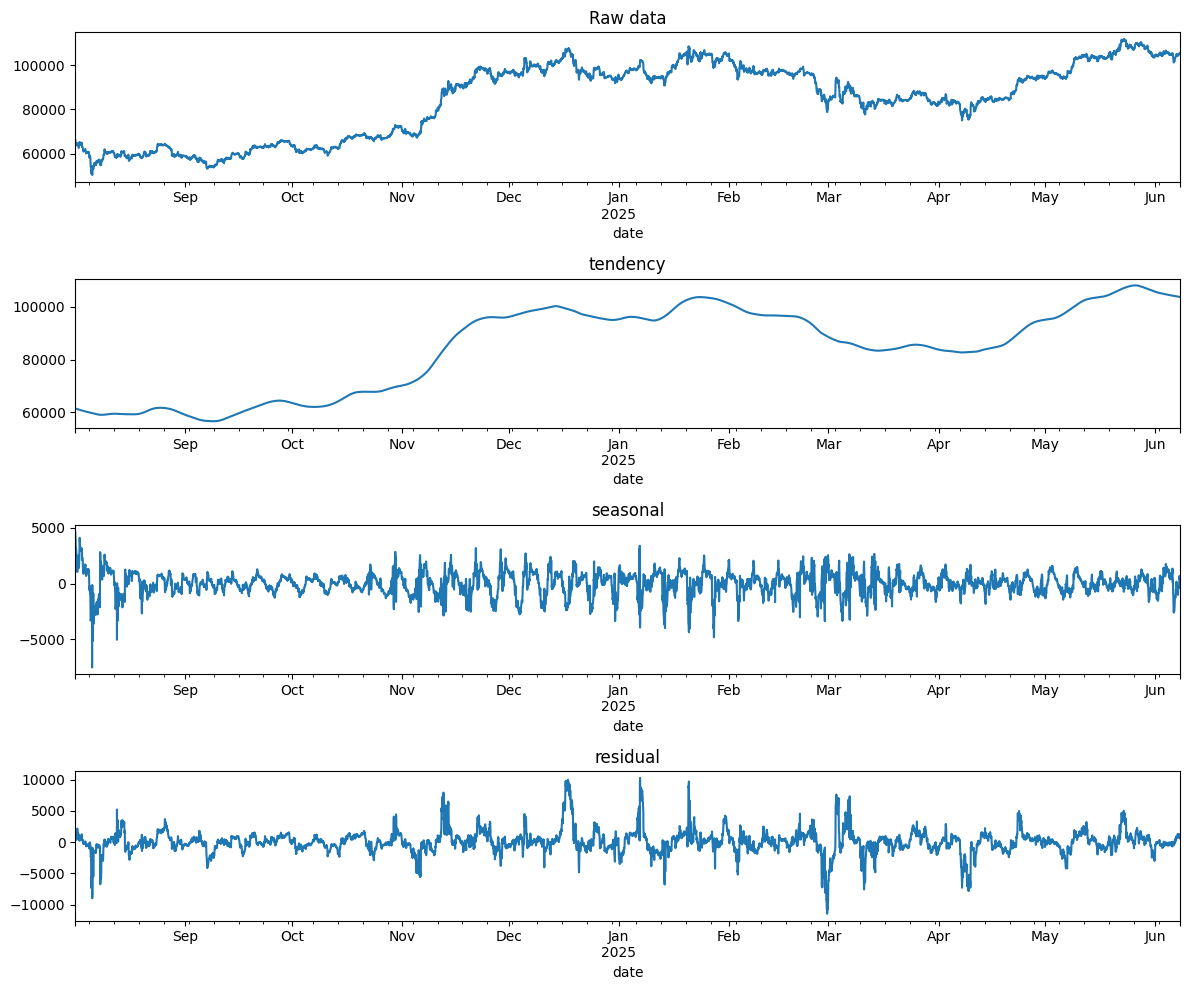

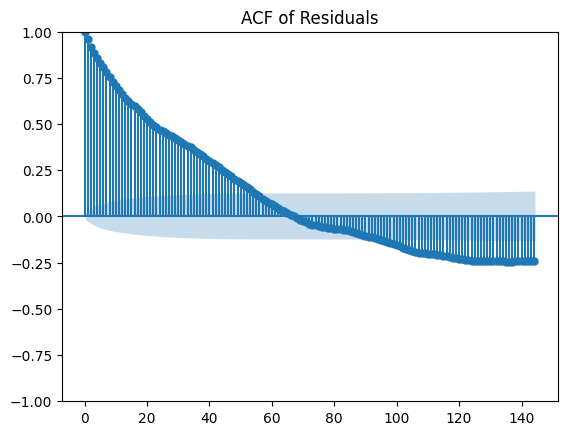

In [ ]:
start = '2024-08-01'
column = "perpetuals_reference_rate"
period = 168
path = "./data/BTC factors/derivatives/BTC_1h_perpetuals_reference_rate.csv"
result_F, factor = stl_factor(path, column, start, period)


from statsmodels.graphics.tsaplots import plot_acf
# Plot ACF of the residual component
plot_acf(result_F.resid.dropna(), lags=144)
plt.title("ACF of Residuals")
plt.show()

STL分解后因子仍然存在大量未被解释的季节性成分，考虑受自回归的影响，考虑ARIMA。

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

def evaluate_stl_residuals(stl_result, alpha=0.05):
    """
    评估STL残差质量
    """
    residuals = stl_result.resid.dropna()
    
    # 1. 残差基本统计
    print("=== 残差基本统计 ===")
    print(f"残差均值: {residuals.mean():.6f}")
    print(f"残差标准差: {residuals.std():.6f}")
    print(f"残差偏度: {stats.skew(residuals):.4f}")
    print(f"残差峰度: {stats.kurtosis(residuals):.4f}")
    
    # 2. Ljung-Box检验（检验自相关性）
    lb_test = acorr_ljungbox(residuals, lags=20, return_df=True)
    print(f"\n=== Ljung-Box检验 (lags=20) ===")
    print(f"Q统计量 p值: {lb_test['lb_pvalue'].iloc[-1]:.4f}")
    if lb_test['lb_pvalue'].iloc[-1] > alpha:
        print("✅ 残差无显著自相关性（通过白噪声检验）")
    else:
        print("❌ 残差存在显著自相关性（未通过白噪声检验）")
    
    # 3. 正态性检验
    _, p_value = stats.normaltest(residuals)
    print(f"\n=== 正态性检验 ===")
    print(f"p值: {p_value:.4f}")
    if p_value > alpha:
        print("✅ 残差近似正态分布")
    else:
        print("⚠️ 残差偏离正态分布")
    
    return residuals

residuals = evaluate_stl_residuals(result_F)

=== 残差基本统计 ===
残差均值: 53.405109
残差标准差: 1864.929261
残差偏度: 0.3530
残差峰度: 7.0703

=== Ljung-Box检验 (lags=20) ===
Q统计量 p值: 0.0000
❌ 残差存在显著自相关性（未通过白噪声检验）

=== 正态性检验 ===
p值: 0.0000
⚠️ 残差偏离正态分布


In [5]:
!pip install tsfresh

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

data = pd.read_csv(path)
data["id"] = 0
data["date"] = pd.to_datetime(data["datetime"])
data = data[["id", "date", column]]
# 假设 df 是长格式：['id', 'time', 'value']
features = extract_features(data, column_id = "id", column_sort='date',
                            default_fc_parameters=MinimalFCParameters())
# 然后根据特征（如 variance、autocorrelation 等）筛选

Feature Extraction: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [ ]:
summary = pd.read_csv("./data/analysis_summary_168_1h.csv")
# 按 'seasonal strength' 降序排序（通常我们关心季节性越强越好）
summary["score"] = summary["seasonal_strength"] + summary["trend_strength"]
summary_sorted = summary.sort_values(by='score', ascending=False)
# 如果你想查看前几行
print(summary_sorted.head())

# 可选：保存排序后的结果
# summary_sorted.to_csv("./data/analysis_summary_sorted.csv", index=False)

                  factor_name original_frequency   category  trend_strength  \
1                       count                10m  addresses        0.999999   
90               active_1m_3m                10m     supply        0.994762   
21   supply_balance_less_0001                10m  addresses        0.927880   
9              non_zero_count                10m  addresses        0.978959   
107                liquid_sum                10m     supply        0.991933   

     seasonal_strength   mean_resid     std_resid  skew_resid  kurtosis_resid  \
1             0.422583  -891.749394  23219.459299   -0.516504        4.497574   
90            0.387972  2890.840000  37354.936219    0.993956        7.158546   
21            0.340105    -0.468203      7.385950   -0.904937        5.269548   
9             0.265927   362.778663  28403.304937    0.540225        7.540421   
107           0.236581   334.187344   4074.203912    0.884999        4.969886   

     lb_pvalue  normal_pvalue  passed_

In [20]:
summary = pd.read_csv("./data/analysis_summary_24_1h.csv")
# 按 'seasonal strength' 降序排序（通常我们关心季节性越强越好）
summary["score"] = summary["seasonal_strength"] + summary["trend_strength"]
summary_sorted = summary.sort_values(by='score', ascending=False)
# 如果你想查看前几行
print(summary_sorted.head())

# 可选：保存排序后的结果
# summary_sorted.to_csv("./data/analysis_summary_sorted.csv", index=False)

                 factor_name original_frequency   category  trend_strength  \
22  supply_balance_more_100k                10m  addresses        0.996643   
13   supply_balance_0001_001                10m  addresses        0.993000   
14     supply_balance_001_01                10m  addresses        0.999887   
9             non_zero_count                10m  addresses        0.995878   
7     min_point_zero_1_count                10m  addresses        0.999850   

    seasonal_strength  mean_resid     std_resid  skew_resid  kurtosis_resid  \
22           0.354885  -99.171084   1485.763687   -3.863043       48.071949   
13           0.296085    0.317676     16.376081   -1.273032       35.097721   
14           0.269490    2.025056     40.184488    0.800518       10.260756   
9            0.254699  230.286447  12721.181066    0.968254       12.431216   
7            0.237293   89.515078   1683.703714    1.202858       14.531557   

    lb_pvalue  normal_pvalue  passed_white_noise  passed

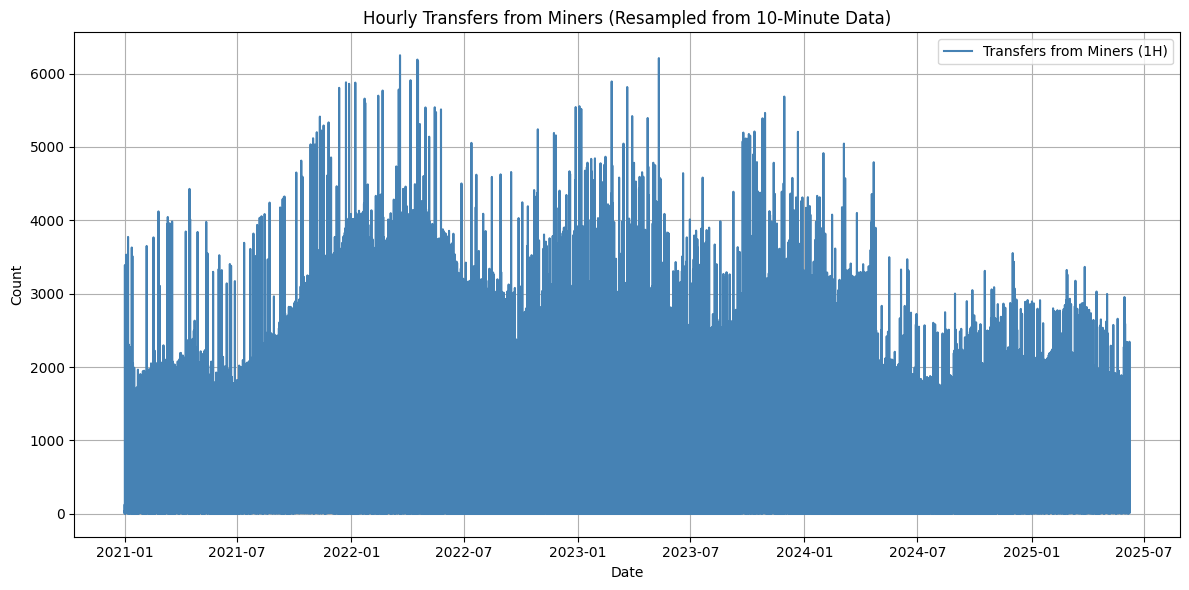

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 指定文件路径
path = "./data/BTC_factors/transactions/BTC_10m_transfers_from_miners_count.csv"

# 检查文件是否存在
if not os.path.exists(path):
    print(f"文件未找到: {path}")
    print("请确认路径是否正确，或上传所需数据文件。")
else:
    # 读取数据
    data = pd.read_csv(path)

    # 转换 datetime 列并设为索引
    data['datetime'] = pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)

    # 重采样为 1 小时频率，对 transfers_from_miners_count 求和
    data_1h = data.resample('1H').sum()
    data_1h.to_csv("./data.csv")
    # 绘图
    plt.figure(figsize=(12, 6))
    plt.plot(data_1h.index, data_1h['transfers_from_miners_count'], label='Transfers from Miners (1H)', color='steelblue')
    plt.title('Hourly Transfers from Miners (Resampled from 10-Minute Data)')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()